In [1]:
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import ultraplot as uplt


# Statsmodels imports
import statsmodels.formula.api as sm
from statsmodels.stats.multitest import fdrcorrection

In [2]:
def prepare_data(prcp_filepath, tmax_filepath, landcover_filepath, area_filepath):
    prcp = pd.read_csv(prcp_filepath)
    tmax = pd.read_csv(tmax_filepath)
    landcover = pd.read_csv(landcover_filepath)
    area = pd.read_csv(area_filepath)

    dest_crs = ccrs.LambertConformal(central_longitude=-76.0, central_latitude=42.0,)
    county = gpd.read_file('./Data/counties_2021.geojson')
    county = county.to_crs(dest_crs)[['ADM2_NAME', 'geometry']]

    combined = gpd.GeoDataFrame(pd.concat([prcp, tmax, landcover, area, county], axis=1))
    combined['perc_defol_area'] = combined['sum']/combined['count']
    
    combined['total_forest'] = combined['deciduous'] + combined['evergreen'] + combined['mixed']
    combined['perc_deciduous'] = combined['deciduous']/combined['total_forest']
    combined['perc_evergreen'] = combined['evergreen']/combined['total_forest']
    combined['perc_mixed'] = combined['mixed']/combined['total_forest']
    combined['perc_defol_area'] = combined['sum']/combined['count']
    
    def standardize(x):
        return (x - x.mean()) / x.std()

    combined['z_prcp_total'] = standardize(combined['total'])
    combined['z_prcp_anom'] = standardize(combined['anom'])
    combined['z_tmax_mean'] = standardize(combined['tmax_mean'])
    combined['z_tmax_anom'] = standardize(combined['tmax_anom'])
    combined['z_perc_deciduous'] = standardize(combined['perc_deciduous'])
    combined['z_perc_evergreen'] = standardize(combined['perc_evergreen'])
    combined['z_perc_mixed'] = standardize(combined['perc_mixed'])
    combined['z_perc_defol_area'] = standardize(combined['perc_defol_area'])
    
    
    return combined

In [3]:
combined = prepare_data('./Data/Enviro/prcp_twelve_month_county_2021.csv', './Data/Enviro/tmax_twelve_month_county_2021.csv', './Data/Enviro/landcover_distribution.csv', './Data/Enviro/defol_area_county_2021.csv')

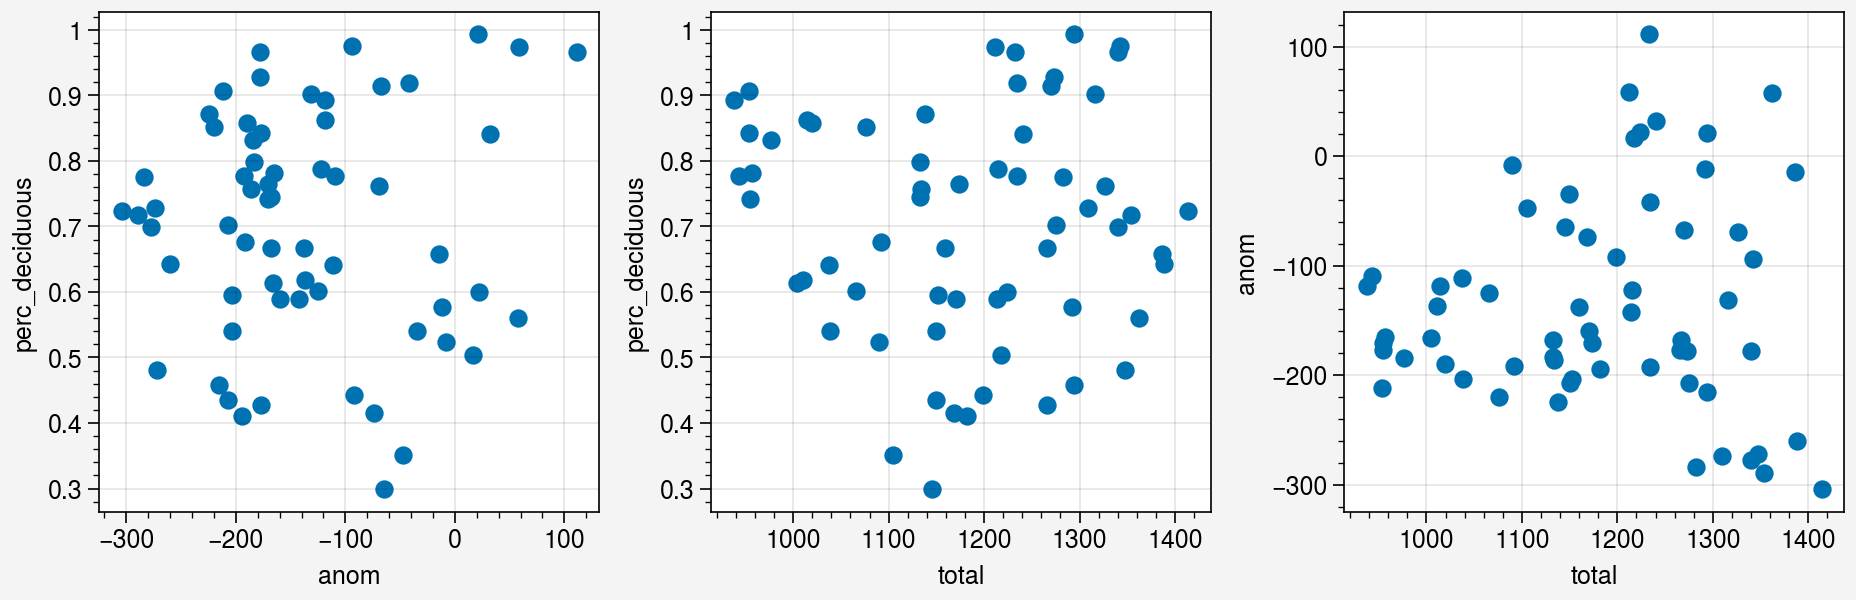

In [4]:
fig, axes = uplt.subplots(ncols=3, share=False)

axes[0].scatter(combined['anom'], combined['perc_deciduous'])
axes[1].scatter(combined['total'], combined['perc_deciduous'])
axes[2].scatter(combined['total'], combined['anom'])

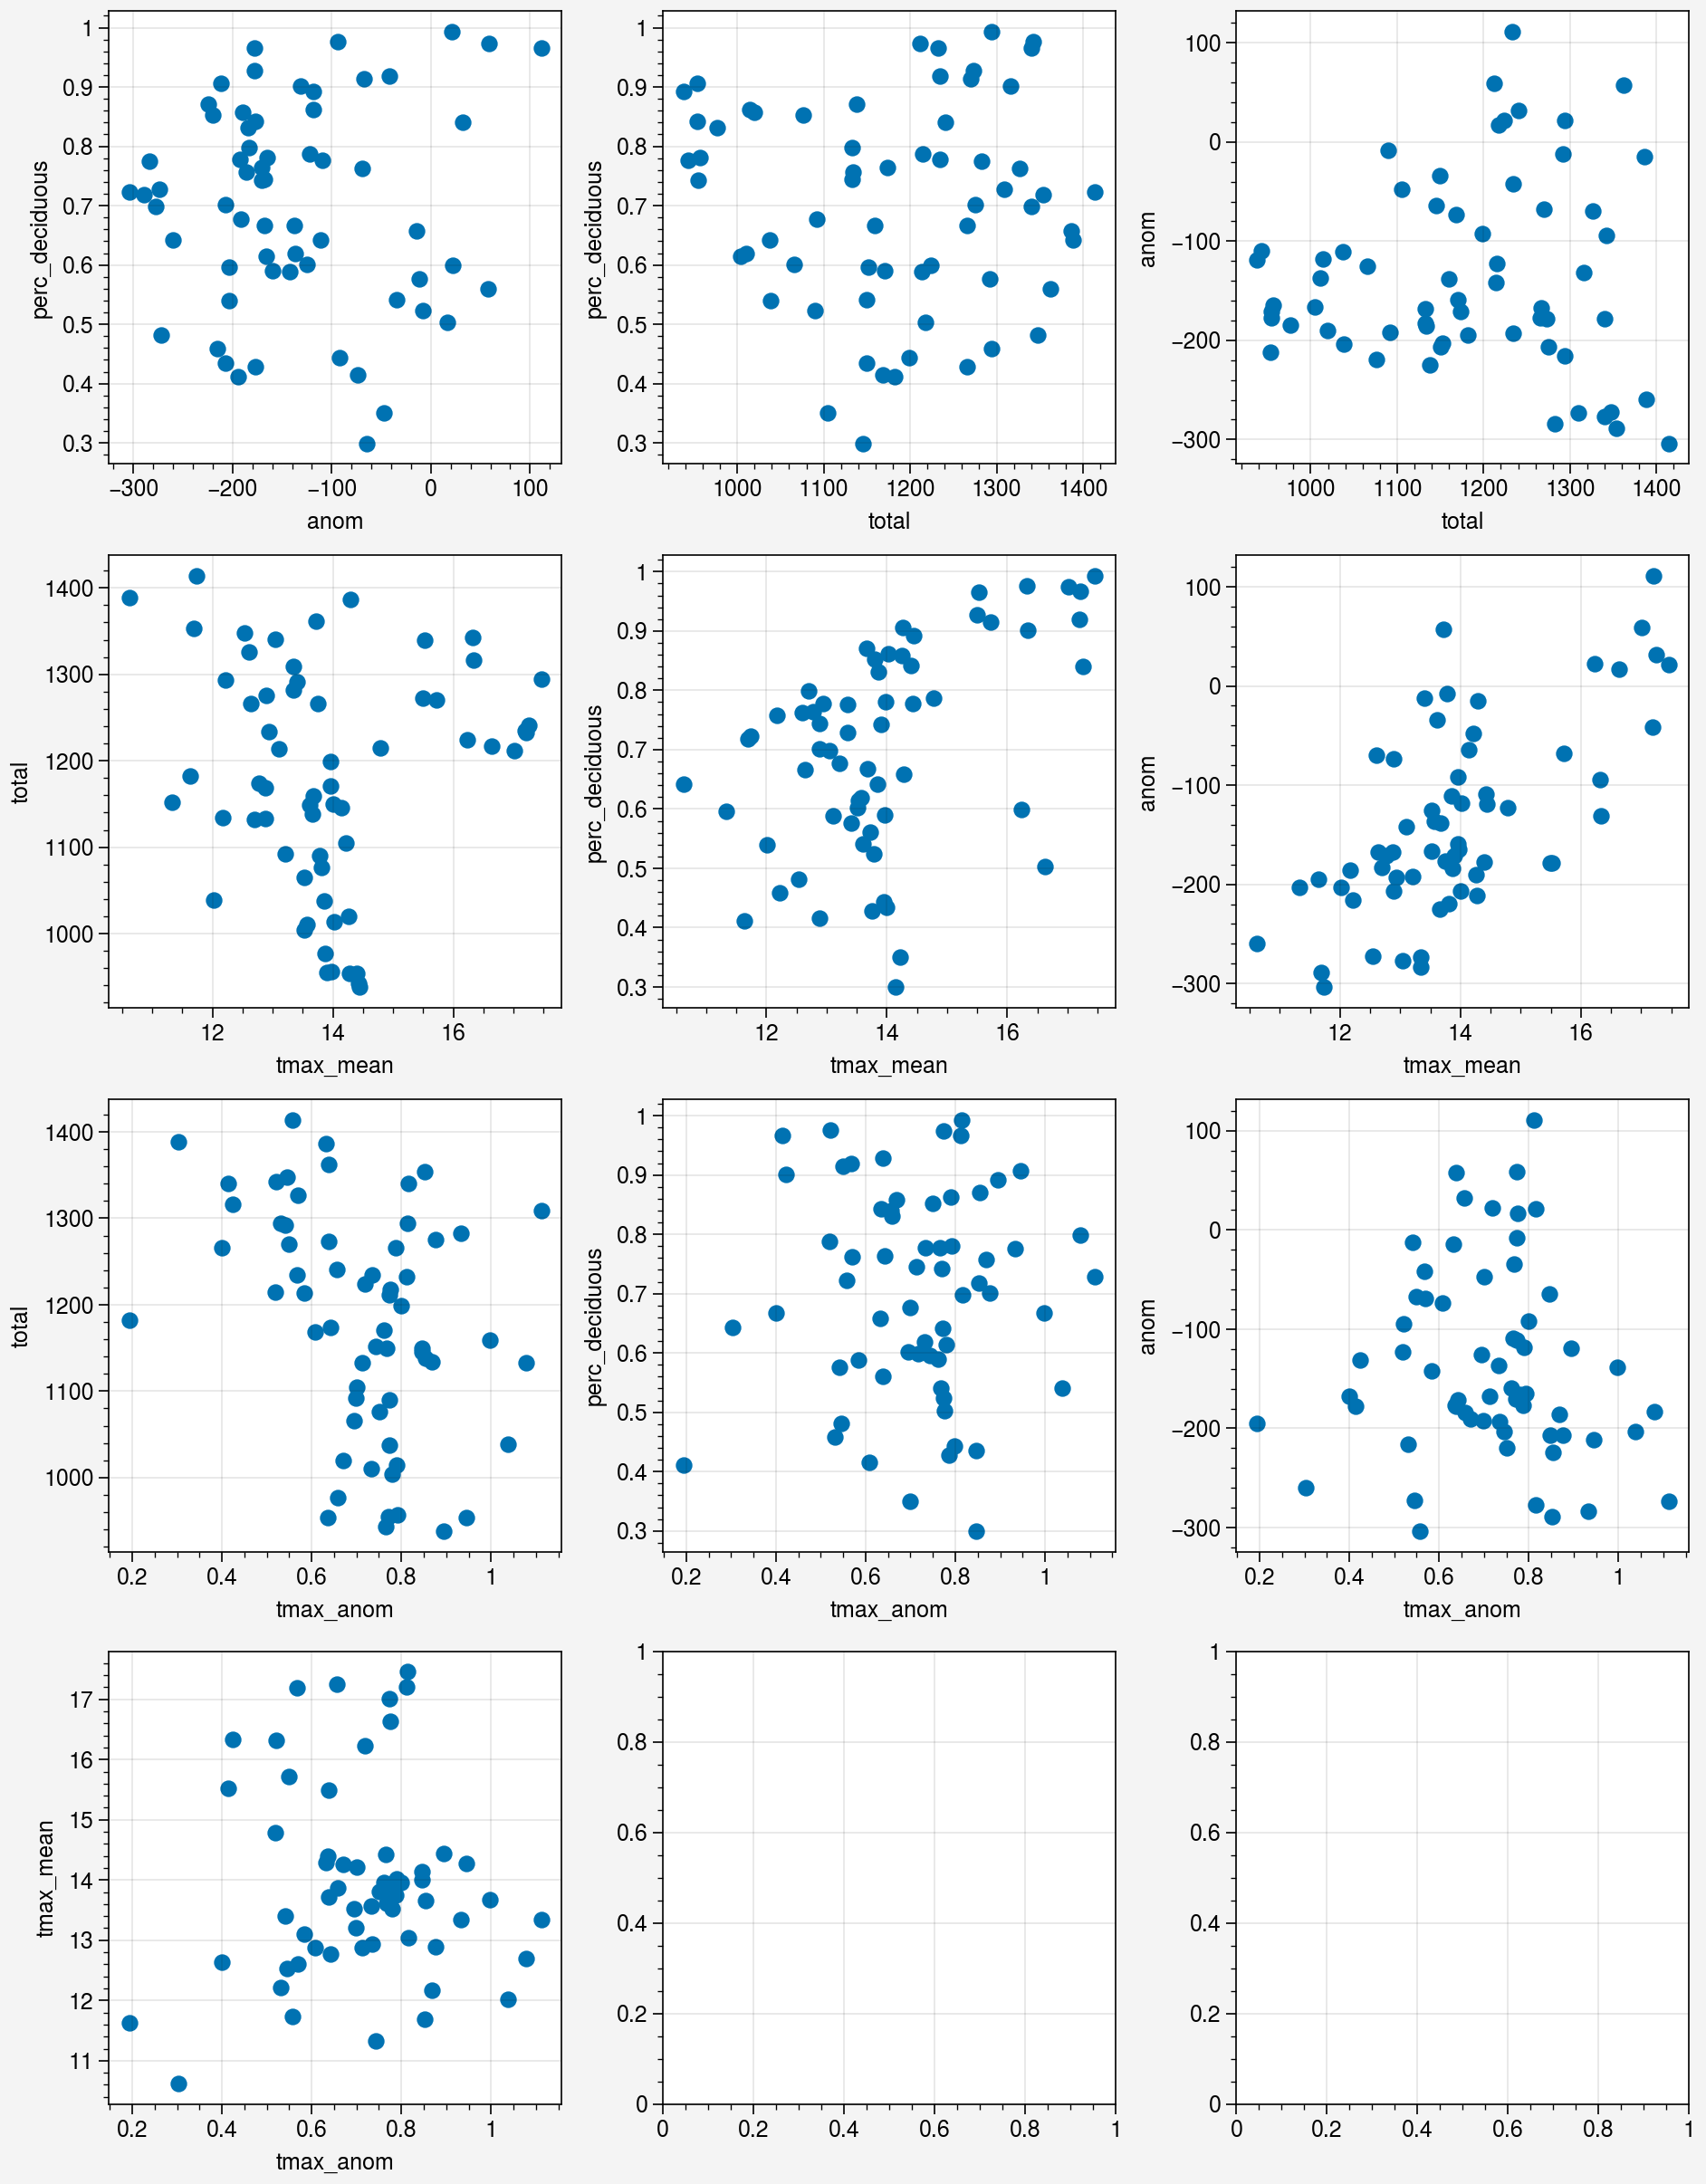

In [5]:
fig, axes = uplt.subplots(ncols=3, nrows=4, share=False)

axes[0].scatter(combined['anom'], combined['perc_deciduous'])
axes[1].scatter(combined['total'], combined['perc_deciduous'])
axes[2].scatter(combined['total'], combined['anom'])

axes[3].scatter(combined['tmax_mean'], combined['total'])
axes[4].scatter(combined['tmax_mean'], combined['perc_deciduous'])
axes[5].scatter(combined['tmax_mean'], combined['anom'])

axes[6].scatter(combined['tmax_anom'], combined['total'])
axes[7].scatter(combined['tmax_anom'], combined['perc_deciduous'])
axes[8].scatter(combined['tmax_anom'], combined['anom'])
axes[9].scatter(combined['tmax_anom'], combined['tmax_mean'])

## Total, Anom, Perc_Deciduous

In [6]:
mod = sm.ols(formula='perc_defol_area ~ z_prcp_total + z_prcp_anom + z_perc_deciduous', data=combined)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        perc_defol_area   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     4.793
Date:                Mon, 28 Apr 2025   Prob (F-statistic):            0.00474
Time:                        09:46:31   Log-Likelihood:                 152.37
No. Observations:                  62   AIC:                            -296.7
Df Residuals:                      58   BIC:                            -288.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0167      0.003  

In [7]:
to_include = res.params[1:].sort_values()

to_include.index

Index(['z_perc_deciduous', 'z_prcp_total', 'z_prcp_anom'], dtype='object')

In [8]:
labels = ['Mean Precipitation', 'Precipitation Anomaly', '% Defoliation']

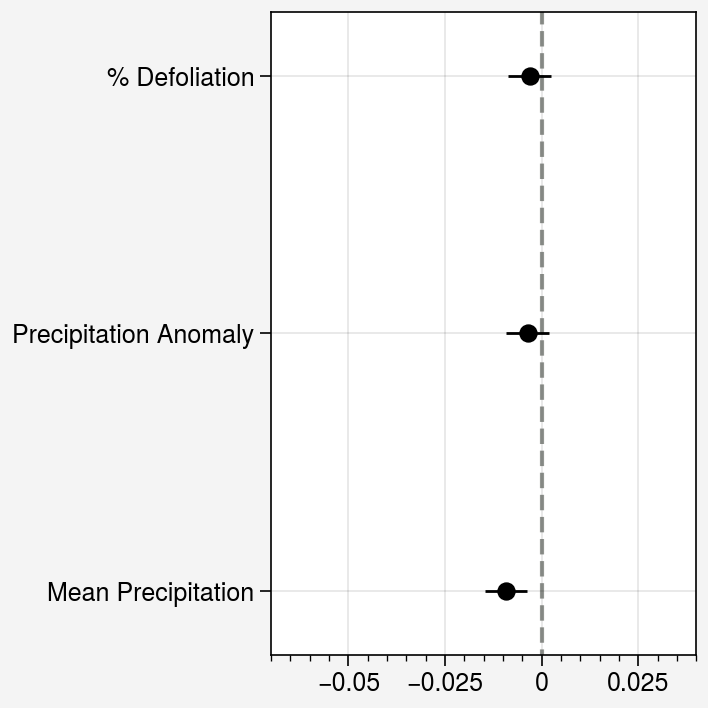

In [9]:
fig, ax = uplt.subplots(figsize=("90mm", "90mm"))

ax.vlines(0, -1, len(to_include), color='gray', zorder=0, linestyle='dashed')

ax.scatter(to_include, range(len(to_include)), color='black', zorder=1)
ax.format(ylocator=range(len(to_include)), yformatter=labels, yminorlocator='null', ylim=[-0.25, len(to_include)-0.75], 
          xlim=[-0.07, 0.04], xlocator=[-0.05, -0.025, 0, 0.025])
#ax.set_yticks(range(len(to_include)), to_include.index)

# add the confidence interval error bars
for idx, ci in enumerate(res.conf_int().loc[to_include.index].iterrows()):
    ax.hlines(idx, ci[1][0], ci[1][1], color="black", zorder=1, linewidth=1)
    
fig.savefig('./Figures/Enviro/Multiple_Regression_Coefficients_Linear_Terms_Only.png')

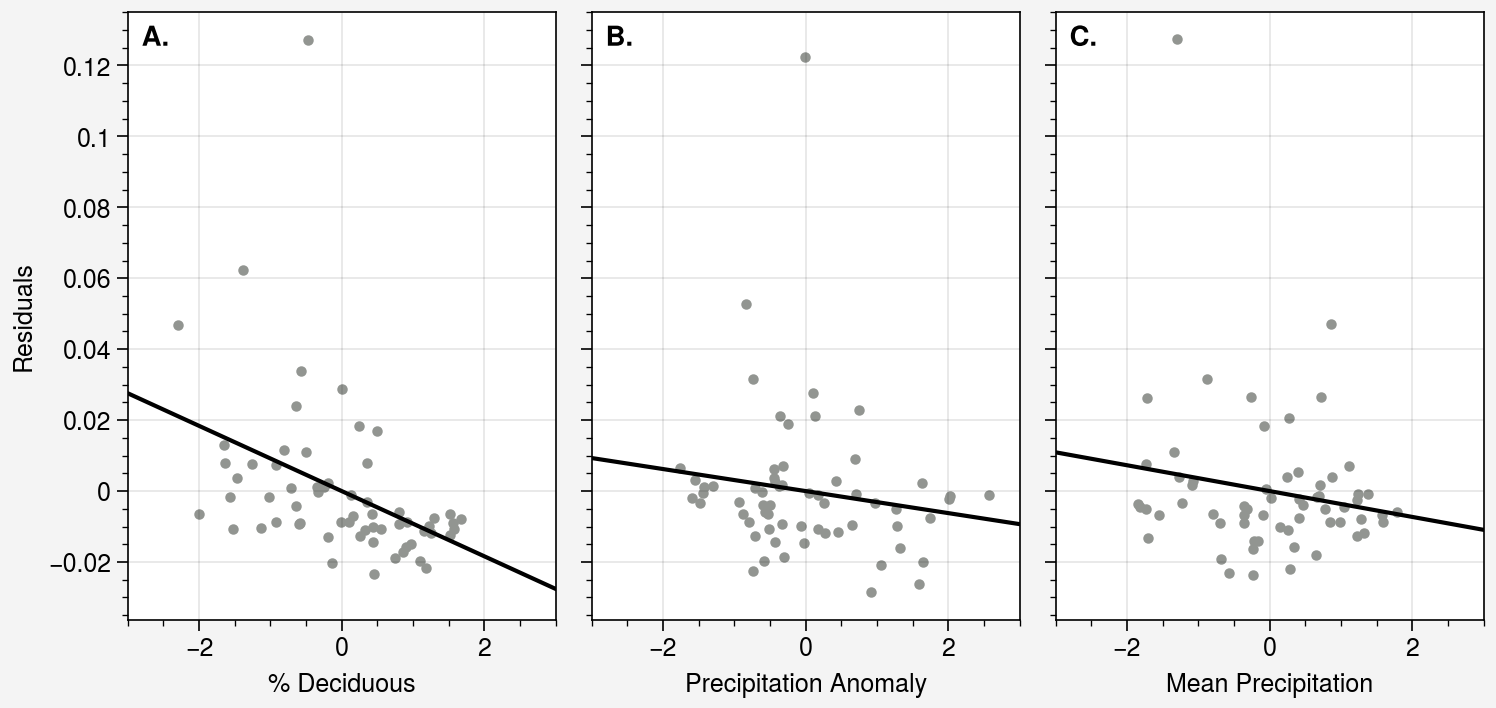

In [10]:
# Partial regressions
fig, axes = uplt.subplots(ncols=3, sharex=False, figsize=("190mm", "90mm"), fontsize=9)

axes.format(abc='A.', abcloc='ul')

x = np.array([-3, 3])

res_x1x2 = sm.ols(formula='perc_defol_area ~ z_prcp_total + z_prcp_anom', data=combined).fit()
p = res_x1x2.params
combined['y_x1x2'] = combined['perc_defol_area'] - (p.Intercept + p.z_prcp_total*combined['z_prcp_total'] + p.z_prcp_anom*combined['z_prcp_anom'])
res_x3 = sm.ols(formula='y_x1x2 ~ z_perc_deciduous', data=combined).fit()
p = res_x3.params

axes[0].scatter(combined['z_perc_deciduous'], combined['y_x1x2'], color='gray', markersize=10)
axes[0].plot(x, p.Intercept + p.z_perc_deciduous*x, color='black')
axes[0].format(xlabel='% Deciduous', ylabel='Residuals')

res_x1x3 = sm.ols(formula='perc_defol_area ~ z_prcp_total + z_perc_deciduous', data=combined).fit()
p = res_x1x3.params
combined['y_x1x3'] = combined['perc_defol_area'] - (p.Intercept + p.z_prcp_total*combined['z_prcp_total'] + p.z_perc_deciduous*combined['z_perc_deciduous'])
res_x2 = sm.ols(formula='y_x1x3 ~ z_prcp_anom', data=combined).fit()
p = res_x2.params

axes[1].scatter(combined['z_prcp_anom'], combined['y_x1x3'], color='gray', markersize=10)
axes[1].plot(x, p.Intercept + p.z_prcp_anom*x, color='black')
axes[1].format(xlabel='Precipitation Anomaly', ylabel='')

res_x2x3= sm.ols(formula='perc_defol_area ~ z_prcp_anom + z_perc_deciduous', data=combined).fit()
p = res_x2x3.params
combined['y_x2x3'] = combined['perc_defol_area'] - (p.Intercept + p.z_prcp_anom*combined['z_prcp_anom'] + p.z_perc_deciduous*combined['z_perc_deciduous'])
res_x1 = sm.ols(formula='y_x2x3 ~ z_prcp_total', data=combined).fit()
p = res_x1.params

axes[2].scatter(combined['z_prcp_total'], combined['y_x2x3'], color='gray', markersize=10)
axes[2].plot(x, p.Intercept + p.z_prcp_total*x, color='black')
axes[2].format(xlabel='Mean Precipitation', ylabel='')

fig.savefig('./Figures/Enviro/Partial_Dependence_Plots.png')

In [11]:
print(res_x1.summary())
print(res_x2.summary())
print(res_x3.summary())

                            OLS Regression Results                            
Dep. Variable:                 y_x2x3   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.823
Date:                Mon, 28 Apr 2025   Prob (F-statistic):              0.182
Time:                        09:46:34   Log-Likelihood:                 152.37
No. Observations:                  62   AIC:                            -300.7
Df Residuals:                      60   BIC:                            -296.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     8.674e-19      0.003   3.24e-16   

## Precip Total, Precip Anom, Perc_Deciduous, Tmax mean, Tmax anom

In [12]:
mod = sm.ols(formula='perc_defol_area ~ z_prcp_total + z_prcp_anom + z_perc_deciduous + z_tmax_mean + z_tmax_anom', data=combined)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        perc_defol_area   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     2.983
Date:                Mon, 28 Apr 2025   Prob (F-statistic):             0.0186
Time:                        09:46:34   Log-Likelihood:                 152.83
No. Observations:                  62   AIC:                            -293.7
Df Residuals:                      56   BIC:                            -280.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0167      0.003  

In [13]:
to_include = res.params[1:].sort_values()

to_include.index

Index(['z_perc_deciduous', 'z_prcp_total', 'z_prcp_anom', 'z_tmax_anom',
       'z_tmax_mean'],
      dtype='object')

In [14]:
labels = ['Mean Precipitation', 'Precipitation Anomaly', 'Max. Temperature Anomaly', '% Defoliation', 'Mean Max. Temperature']

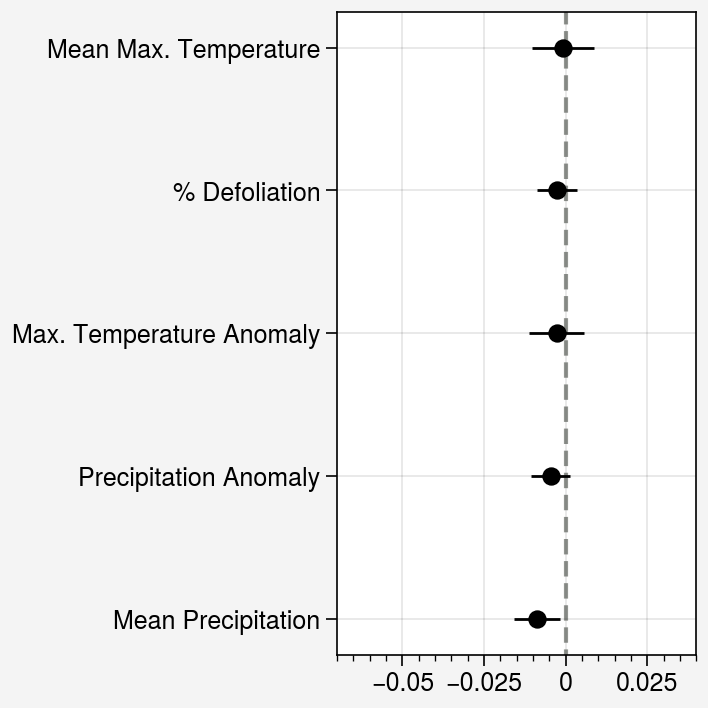

In [15]:
fig, ax = uplt.subplots(figsize=("90mm", "90mm"))

ax.vlines(0, -1, len(to_include), color='gray', zorder=0, linestyle='dashed')

ax.scatter(to_include, range(len(to_include)), color='black', zorder=1)
ax.format(ylocator=range(len(to_include)), yformatter=labels, yminorlocator='null', ylim=[-0.25, len(to_include)-0.75], 
          xlim=[-0.07, 0.04], xlocator=[-0.05, -0.025, 0, 0.025])
#ax.set_yticks(range(len(to_include)), to_include.index)

# add the confidence interval error bars
for idx, ci in enumerate(res.conf_int().loc[to_include.index].iterrows()):
    ax.hlines(idx, ci[1][0], ci[1][1], color="black", zorder=1, linewidth=1)
    
#fig.savefig('./Figures/Enviro/Multiple_Regression_Coefficients_Linear_Terms_Only.png')

In [16]:
res.pvalues[1:]

z_prcp_total        0.128517
z_prcp_anom         0.518038
z_perc_deciduous    0.015590
z_tmax_mean         0.866507
z_tmax_anom         0.384118
dtype: float64

In [17]:
fdrcorrection(res.pvalues[1:], alpha=0.05, method='indep', is_sorted=False)

(array([False, False, False, False, False]),
 array([0.3212931 , 0.64754773, 0.07794968, 0.86650686, 0.6401968 ]))

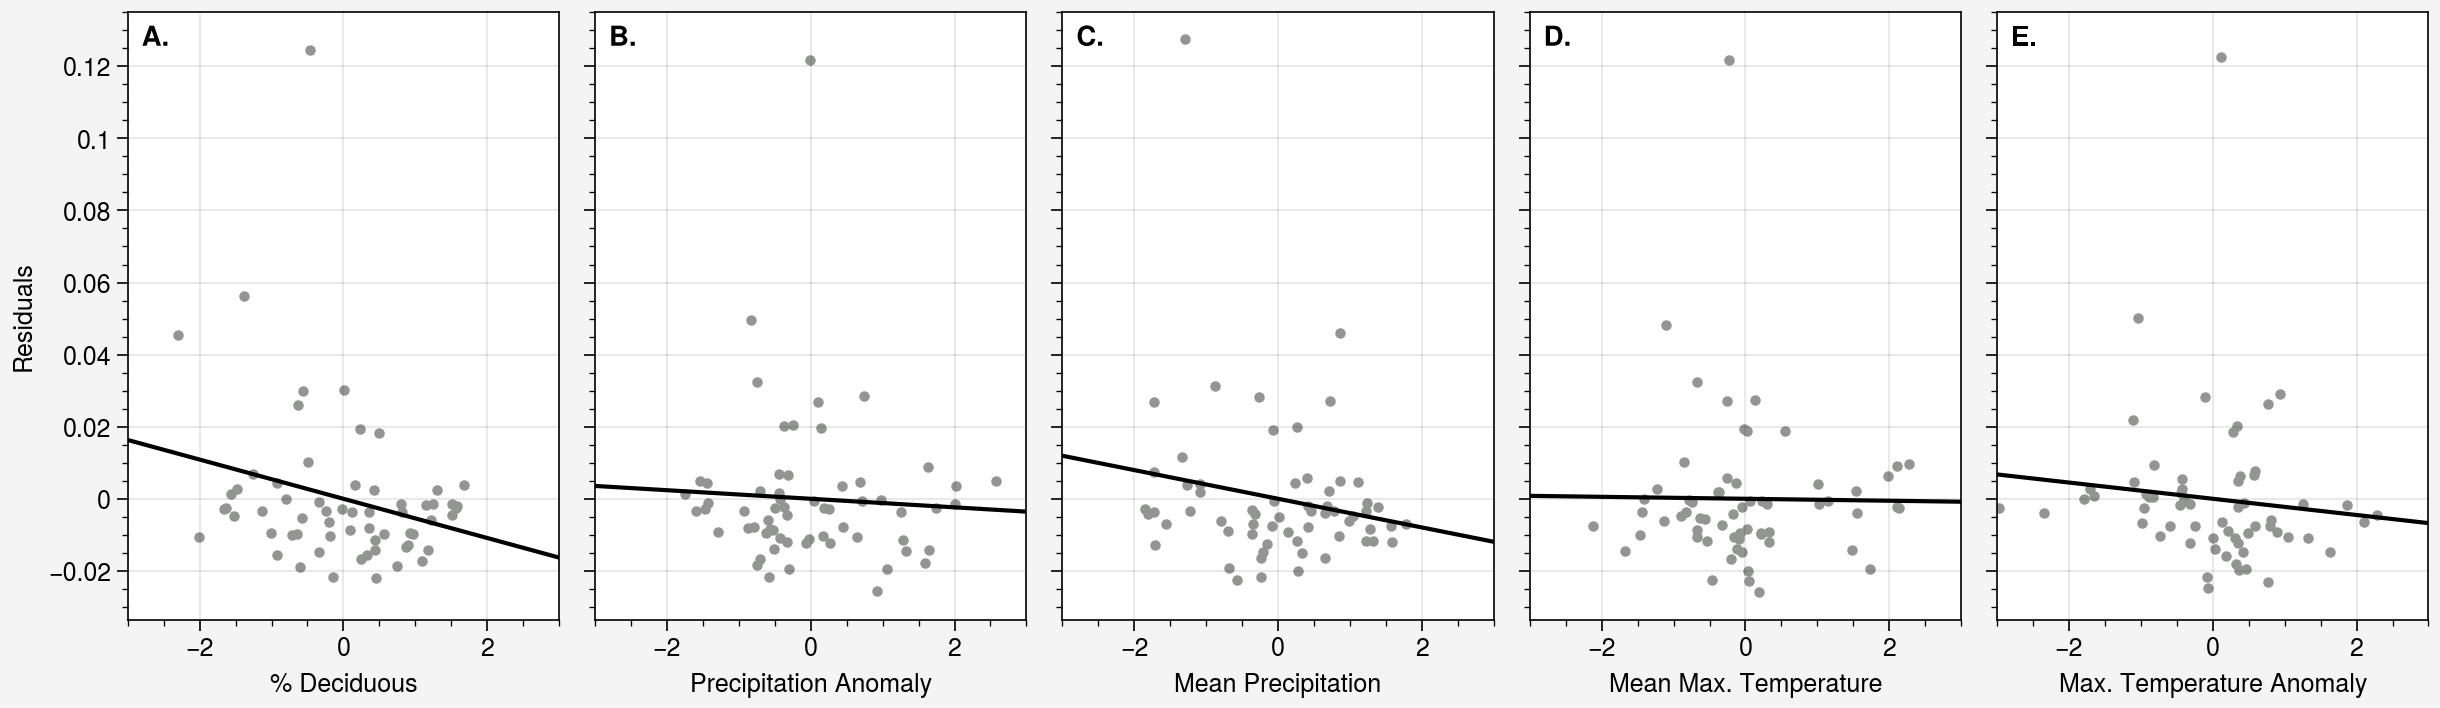

In [18]:
# Partial regressions
fig, axes = uplt.subplots(ncols=5, sharex=False, figsize=("310mm", "90mm"), fontsize=9)

axes.format(abc='A.', abcloc='ul')

x = np.array([-3, 3])

res_x1x2x4x5 = sm.ols(formula='perc_defol_area ~ z_prcp_total + z_prcp_anom + z_tmax_mean + z_tmax_anom', data=combined).fit()
p = res_x1x2x4x5.params
combined['y_x1x2x4x5'] = combined['perc_defol_area'] - (p.Intercept + 
                                                    p.z_prcp_total*combined['z_prcp_total'] + 
                                                    p.z_prcp_anom*combined['z_prcp_anom'] +
                                                    p.z_tmax_mean*combined['z_tmax_mean'] +
                                                    p.z_tmax_anom*combined['z_tmax_anom'])
res_x3 = sm.ols(formula='y_x1x2x4x5 ~ z_perc_deciduous', data=combined).fit()
p = res_x3.params

axes[0].scatter(combined['z_perc_deciduous'], combined['y_x1x2x4x5'], color='gray', markersize=10)
axes[0].plot(x, p.Intercept + p.z_perc_deciduous*x, color='black')
axes[0].format(xlabel='% Deciduous', ylabel='Residuals')

res_x1x3x4x5 = sm.ols(formula='perc_defol_area ~ z_prcp_total + z_perc_deciduous + z_tmax_mean + z_tmax_anom', data=combined).fit()
p = res_x1x3x4x5.params
combined['y_x1x3x4x5'] = combined['perc_defol_area'] - (p.Intercept + 
                                                    p.z_prcp_total*combined['z_prcp_total'] + 
                                                    p.z_perc_deciduous*combined['z_perc_deciduous'] +
                                                    p.z_tmax_mean*combined['z_tmax_mean'] +
                                                    p.z_tmax_anom*combined['z_tmax_anom'])
res_x2 = sm.ols(formula='y_x1x3x4x5 ~ z_prcp_anom', data=combined).fit()
p = res_x2.params

axes[1].scatter(combined['z_prcp_anom'], combined['y_x1x3x4x5'], color='gray', markersize=10)
axes[1].plot(x, p.Intercept + p.z_prcp_anom*x, color='black')
axes[1].format(xlabel='Precipitation Anomaly', ylabel='')

res_x2x3x4x5= sm.ols(formula='perc_defol_area ~ z_prcp_anom + z_perc_deciduous + z_tmax_mean + z_tmax_anom', data=combined).fit()
p = res_x2x3x4x5.params
combined['y_x2x3x4x5'] = combined['perc_defol_area'] - (p.Intercept + 
                                                    p.z_prcp_anom*combined['z_prcp_anom'] + 
                                                    p.z_perc_deciduous*combined['z_perc_deciduous'] +
                                                    p.z_tmax_mean*combined['z_tmax_mean'] +
                                                    p.z_tmax_anom*combined['z_tmax_anom'])
res_x1 = sm.ols(formula='y_x2x3x4x5 ~ z_prcp_total', data=combined).fit()
p = res_x1.params

axes[2].scatter(combined['z_prcp_total'], combined['y_x2x3x4x5'], color='gray', markersize=10)
axes[2].plot(x, p.Intercept + p.z_prcp_total*x, color='black')
axes[2].format(xlabel='Mean Precipitation', ylabel='')

res_x1x2x3x5= sm.ols(formula='perc_defol_area ~ z_prcp_total + z_prcp_anom + z_perc_deciduous + z_tmax_anom', data=combined).fit()
p = res_x1x2x3x5.params
combined['y_x1x2x3x5'] = combined['perc_defol_area'] - (p.Intercept + 
                                                    p.z_prcp_anom*combined['z_prcp_anom'] + 
                                                    p.z_perc_deciduous*combined['z_perc_deciduous'] +
                                                    p.z_prcp_total*combined['z_prcp_total'] +
                                                    p.z_tmax_anom*combined['z_tmax_anom'])
res_x4 = sm.ols(formula='y_x1x2x3x5 ~ z_tmax_mean', data=combined).fit()
p = res_x4.params

axes[3].scatter(combined['z_tmax_mean'], combined['y_x1x2x3x5'], color='gray', markersize=10)
axes[3].plot(x, p.Intercept + p.z_tmax_mean*x, color='black')
axes[3].format(xlabel='Mean Max. Temperature', ylabel='')

res_x1x2x3x4= sm.ols(formula='perc_defol_area ~ z_prcp_total + z_prcp_anom + z_perc_deciduous + z_tmax_mean', data=combined).fit()
p = res_x1x2x3x4.params
combined['y_x1x2x3x4'] = combined['perc_defol_area'] - (p.Intercept + 
                                                    p.z_prcp_anom*combined['z_prcp_anom'] + 
                                                    p.z_perc_deciduous*combined['z_perc_deciduous'] +
                                                    p.z_prcp_total*combined['z_prcp_total'] +
                                                    p.z_tmax_mean*combined['z_tmax_mean'])
res_x5 = sm.ols(formula='y_x1x2x3x4 ~ z_tmax_anom', data=combined).fit()
p = res_x5.params

axes[4].scatter(combined['z_tmax_anom'], combined['y_x1x2x3x4'], color='gray', markersize=10)
axes[4].plot(x, p.Intercept + p.z_tmax_anom*x, color='black')
axes[4].format(xlabel='Max. Temperature Anomaly', ylabel='')

#fig.savefig('./Figures/Enviro/Partial_Dependence_Plots.png')

## Total, Anom, Perc_Deciduous, Perc_Evergreen, Perc_Mixed

In [19]:
mod = sm.ols(formula=('perc_defol_area ~ z_prcp_total + z_prcp_anom + z_perc_deciduous + z_tmax_mean + z_tmax_anom +' +
                      'z_prcp_anom*z_prcp_total + z_prcp_anom*z_perc_deciduous + z_prcp_total*z_perc_deciduous + ' +
                      'z_tmax_mean*z_prcp_total + z_tmax_mean*z_prcp_anom + z_tmax_mean*z_perc_deciduous + ' +
                      'z_tmax_anom*z_prcp_total + z_tmax_anom*z_prcp_anom + z_tmax_anom*z_perc_deciduous + z_tmax_anom*z_tmax_mean'), data=combined)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        perc_defol_area   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     1.272
Date:                Mon, 28 Apr 2025   Prob (F-statistic):              0.258
Time:                        09:46:36   Log-Likelihood:                 156.26
No. Observations:                  62   AIC:                            -280.5
Df Residuals:                      46   BIC:                            -246.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [20]:
labels = ['Mean Precipitation', 'Precipitation Anomaly', '% Deciduous', r'$T_{max}$ Mean', r'$T_{max}$ Anomaly',
          'Precip. Anom. x Mean Precip.', 'Precip. Anom. x % Deciduous', 'Mean Precip. x % Deciduous', r'$T_{max}$ Mean x Mean Precip.',
          r'$T_{max}$ Mean x Precip. Anom.', r'$T_{max}$ Mean x % Deciduous', r'$T_{max}$ Anomaly x Mean Precip.',
          r'$T_{max}$ Anomaly x Precip. Anom.', r'$T_{max}$ Anomaly x % Deciduous', r'$T_{max}$ Anomaly x $T_{max}$ Mean']

C:\Users\camer\AppData\Local\Temp\ipykernel_32312\784739415.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.hlines(len(to_include) - idx - 1, ci[1][0], ci[1][1], color=['black', 'red'][colors[idx]], zorder=1, linewidth=1)


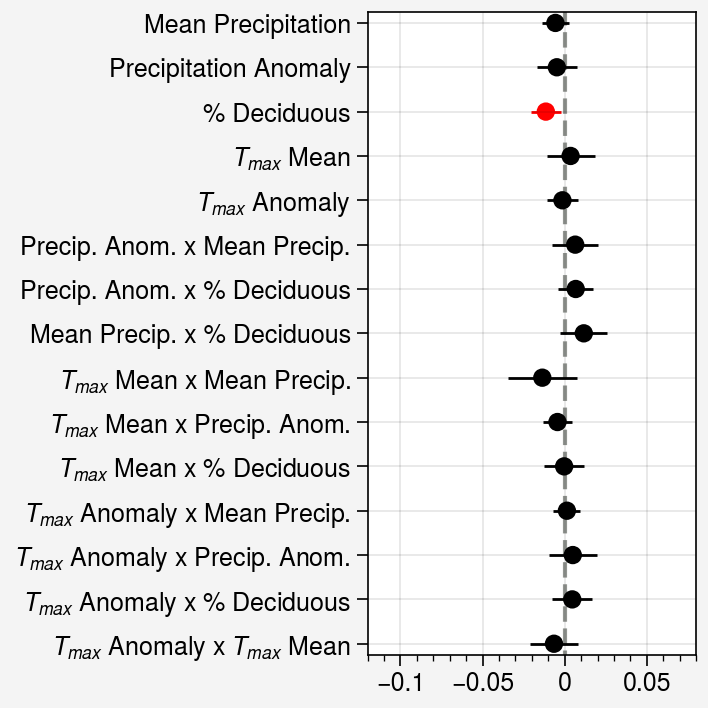

In [21]:
to_include = res.params[1:]
colors = (res.pvalues[1:] < 0.05).astype(int)

fig, ax = uplt.subplots(figsize=("90mm", "90mm"), fontsize=9)

ax.vlines(0, -1, len(to_include), color='gray', zorder=0, linestyle='dashed')

# add the confidence interval error bars
for idx, ci in enumerate(res.conf_int().loc[to_include.index].iterrows()):
    ax.hlines(len(to_include) - idx - 1, ci[1][0], ci[1][1], color=['black', 'red'][colors[idx]], zorder=1, linewidth=1)

ax.scatter(to_include, range(len(to_include)-1, -1, -1), color=colors, cmap=['black', 'red'], zorder=1)
ax.format(ylocator=range(len(to_include)-1, -1, -1), yformatter=labels, yminorlocator='null', ylim=[-0.25, len(to_include)-0.75], 
          xlim=[-0.12, 0.08], xlocator=[-0.10, -0.05, 0, 0.05])

fig.savefig('./Figures/Enviro/Multiple_Regression_Coefficients_Interaction_Terms.png')

# Variable correlation matrix
This is a good supplementary to provide some insight into possibly colinearities in independent variables

In [22]:
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
limited = combined[["z_prcp_total", "z_prcp_anom", "z_tmax_mean", "z_tmax_anom", "z_perc_deciduous"]]

In [ ]:
mm = 1/2.54/10
p = sns.pairplot(limited, height=37*mm)
p.fig.set_size_inches(190*mm, 190*mm)
p.savefig('./Figures/Enviro/Independent_Variables_Pairplot.png')

In [ ]:
np.count_nonzero(limited['z_tmax_mean'] < -1)

In [ ]:
8/61

In [ ]:
# Plotting correlation heatmap
dataplot = sns.heatmap(limited.corr(numeric_only=True), cmap="YlGnBu", annot=True)

# Displaying heatmap
pplt.show()

In [ ]:
fig, ax = pplt.subplots()

ax.heatmap(
    limited.corr()[::-1], cmap='rocket',
    labels=True, precision=2, labels_kw={'weight': 'bold'}
)
ax.format(title='Heatmap with labels')